# Yewno Quantitative Assignment - Yunzhe Fang
# Smart Beta Strategies

## 1. Benchmark Components

<b>Benchmark:</b> NASDAQ 100 Index<br>

The Nasdaq-100 Index includes 100 of the largest domestic and international non-financial companies listed on The Nasdaq Stock Market based on market capitalization. The Index reflects companies across major industry groups including computer hardware and software, telecommunications, retail/wholesale trade and biotechnology.

<b>Weights Review Frequency:</b> Quarterly basis

<b>Data Source</b>: Yahoo Finance<br>
<b>Data Type</b>: Daily price & Volume<br>

### 1.1 Download & Preprocess Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

In [2]:
#input the components of the index
ComponentList = open("C:/Users/Yunzhe Fang/Desktop/yewno/2. Smart Beta/1.data/nasdaq100list.csv").readlines()[0].replace("\n","").split(",")
yf.pdr_override()

#download the pricedata
stockdata = pdr.get_data_yahoo(tickers=ComponentList,start="2009-01-01",end="2018-03-01",as_panel = False)

#calculate return
closeadj=stockdata["Adj Close"]
DailyReturn=(closeadj-closeadj.shift(1))/closeadj.shift(1)  * 100
DailyReturn=DailyReturn.drop(DailyReturn.index[0]).dropna(axis=1)

[*********************100%***********************]  104 of 104 downloaded


### 1.2 Benchmark: Nasdaq 100 Index

[*********************100%***********************]  1 of 1 downloaded


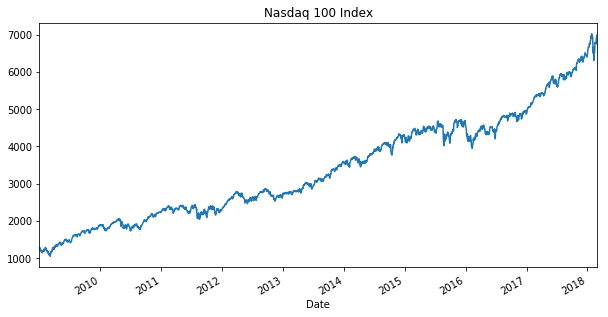

In [6]:
#download the NDX data
NDX = yf.download("^NDX",start="2009-01-01",end="2018-03-01")
NDX['Adj Close'].plot(figsize=(10,5)).set_title("Nasdaq 100 Index")
plt.show()
#NDX return
NDXreturn=(NDX['Adj Close']-NDX['Adj Close'].shift(1))/NDX['Adj Close'].shift(1)  * 100
NDXreturn= NDXreturn.drop(NDXreturn.index[0])

## 2. Risk based Smart beta strategies

The "Nasdaq 100 index" is based on <b>market capitalization weighted</b>.<br>

There are some advantages of the market-cap indexation. Basically, market capitalization is a convenient and clear way to participate to the equity market, and the corresponding index has a lower turnover as well as transaction costs.<br>

The disadvantages are also very obvious, such as lack of risk diversification and growth bias as high valuation stocks might weight more than low valuation stocks. And it is a concentrated portfolios, as the top 10 market caps of the Nasdaq 100 account for around 50%.<br>

I used three different methods to generate weightings according to two cons of the "market capitalization weighted" index:<br> 
<b>1."concentrated problem"</b>: Equally Weighted<br>
<b>2."less risk diversification</b>: Minimum Variance and Equal Risk Contribution (ERC).

In [10]:
from numpy.linalg import inv,pinv
from scipy.optimize import minimize
from dateutil.relativedelta import relativedelta
import datetime
import pyfolio as pf

In [18]:
# Weight review datetime - Quarterly review
firstDay = DailyReturn.index[0]
LastDay = DailyReturn.index[-1]
reviewDate = [datetime.date(firstDay.year, firstDay.month, 1).strftime('%Y-%m-%d')]

while firstDay <= LastDay:
    firstDay += relativedelta(months=3)
    reviewDate.append(datetime.date(firstDay.year, firstDay.month, 1).strftime('%Y-%m-%d'))
    reviewDate.append(datetime.date(firstDay.year, firstDay.month, 2).strftime('%Y-%m-%d'))
reviewDate=reviewDate[0:-1]

### 2.1 Equally Weight - Comparasion

In [25]:
def Equally_weight(Cov,numStock):
    return [1/numStock]*93

### 2.2 Minimum Variance

In [28]:
def Minimum_variance_weight(Cov,numStock):
    
    def portfolio_variance(w,Cov):
        # calculate the risk of the portfolio
        # w - Weight
        # Cov - covariance matrix
        w = np.matrix(w)
        Cov = np.matrix(Cov)
        return (w*Cov*w.T)[0,0]
    
    # No unconstrained conditions
    constraints = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1.0})
    w0 = [1/numStock]*93
    
    res= minimize(portfolio_variance, w0, args=Cov, method='SLSQP',constraints=constraints,options={'disp': False})
    return list(res.x)

### 2.3 Equal Risk Contribution (ERC)

In [36]:
def Equal_risk_contribution_weight(Cov,numStock):

    def portfolio_variance(w,Cov):
        # calculate the risk of the portfolio
        # w - Weight
        # Cov - covariance matrix
        w = np.matrix(w)
        Cov = np.matrix(Cov)
        return (w*Cov*w.T)[0,0]


    def risk_contribution(w,Cov):
        # calculate each asset's contribution to the total risk
        w = np.matrix(w)
        Cov = np.matrix(Cov)
        sigma = np.sqrt(portfolio_variance(w,Cov))

        # Marginal risk Contribution
        MarginalRiskContribution = Cov*w.T

        # Risk Contribution
        RiskContribution = np.multiply(MarginalRiskContribution,w.T)/sigma
        return RiskContribution


    def obj_risk_budget(x,pars):
        # calculate the portfolio risk
        Cov = pars[0] # covariance table
        x_t = pars[1] # risk target in percent of portfolio risk
        sig_p =  np.sqrt(portfolio_variance(x,Cov)) # portfolio sigma
        risk_target = np.asmatrix(np.multiply(sig_p,x_t))
        asset_RiskContribution = risk_contribution(x,Cov)
        J = sum(np.square(asset_RiskContribution-risk_target.T))[0,0] # sum of squared error
        return J

    def total_weight_constraint(x):
        return np.sum(x)-1.0

    def long_only_constraint(x):
        return x

    x_t = [1/numStock]*numStock  #equal risk, initial weights
    w0 = [1/numStock]*93

    constraints = ({'type': 'eq', 'fun': total_weight_constraint}, {'type': 'ineq', 'fun': long_only_constraint})
    res= minimize(obj_risk_budget, w0, args=[Cov,x_t], method='SLSQP',constraints=constraints, options={'disp': False})
    
    return list(res.x)

### 2.4 Backtest
<b>Pyfolio</b> is used to perform the performance analysis and risk analysis of the back testing.

Weightings will be adjusted every quarter using based on the covariance matrix of last quarter.

In [38]:
def Generate_returns(DailyReturn,reviewDate,weightfunction):
    SmartBetaReturn = pd.Series()
    numStock = DailyReturn.shape[1]
    i=0
    for j in range(0,int(len(reviewDate)/2)-1):
        Cov = DailyReturn.truncate(before=reviewDate[i],after=reviewDate[i+1]).cov()
        returntemp = DailyReturn.truncate(before=reviewDate[i+2],after=reviewDate[i+3])
        SmartBetaReturn=SmartBetaReturn.append(pd.Series((weightfunction(Cov,numStock)*np.asmatrix(returntemp).T).tolist()[0],index=returntemp.index,name="Return"))
        i=i+2
    return SmartBetaReturn

def pyfolio_analyze(portfolioReturn,BenchmarkReturn):
    backtest_result=pf.create_returns_tear_sheet(returns=portfolioReturn/100,benchmark_rets=BenchmarkReturn/100,)

In [39]:
returns1 = Generate_returns(DailyReturn,reviewDate,Equally_weight)
returns2 = Generate_returns(DailyReturn,reviewDate,Minimum_variance_weight)
returns3 = Generate_returns(DailyReturn,reviewDate,Equal_risk_contribution_weight)

In [55]:
allreturns=pd.DataFrame(pf.ep.cum_returns(returns=returns1/100),columns=['Equally_weight'])
allreturns['Minimum_variance_weight']=pf.ep.cum_returns(returns=returns2/100)
allreturns['Equal_risk_contribution_weight']=pf.ep.cum_returns(returns=returns3/100)
allreturns['Nasdaq100']=pf.ep.cum_returns(returns=NDXreturn/100)

### 2.5 Results

As the cumulative return chart shows, all three smart beta strategies outperformed the benchmark index a lot. The <b>Equal Risk Contribution strategy</b> has the highest Sharpe Ratio and relatively stable performance, so I think it might be the best among all three "smart beta" strategies.


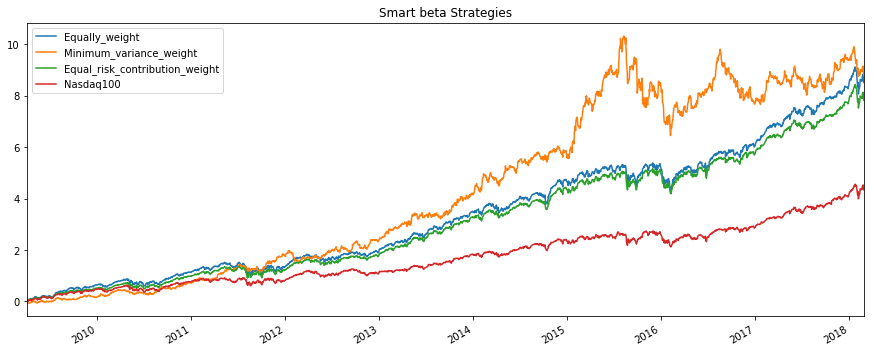

In [59]:
allreturns.plot(figsize=(15,6)).set_title("Smart beta Strategies")
plt.show()

<b>Equal Risk Contribution (ERC) strategy - Performance & risk analysis</b>

Entire data start date: 2009-04-02
Entire data end date: 2018-03-01
Backtest months: 106


Backtest
Annual return          27.7%
Cumulative returns    781.7%
Annual volatility      16.5%
Sharpe ratio            1.56
Calmar ratio            1.44
Stability               0.98
Max drawdown          -19.3%
Omega ratio             1.32
Sortino ratio           2.27
Skew                   -0.37
Kurtosis                3.06
Tail ratio              0.99
Daily value at risk    -2.0%
Alpha                   0.07
Beta                    0.92

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  19.29 2011-07-07  2011-08-08    2012-01-19   
1                                  15.71 2015-12-01  2016-02-11    2016-05-27   
2                                  13.14 2010-04-29  2010-07-06    2010-09-20   
3                                  12.05 2015-08-05  2015-09-29    2015-11-02   
4                                   9.70 2018-01-26  2018-02-08           NaT   

Worst drawdown periods Duration  
0                           141  
1                           129  
2                           103  
3                            64  
4                           NaN

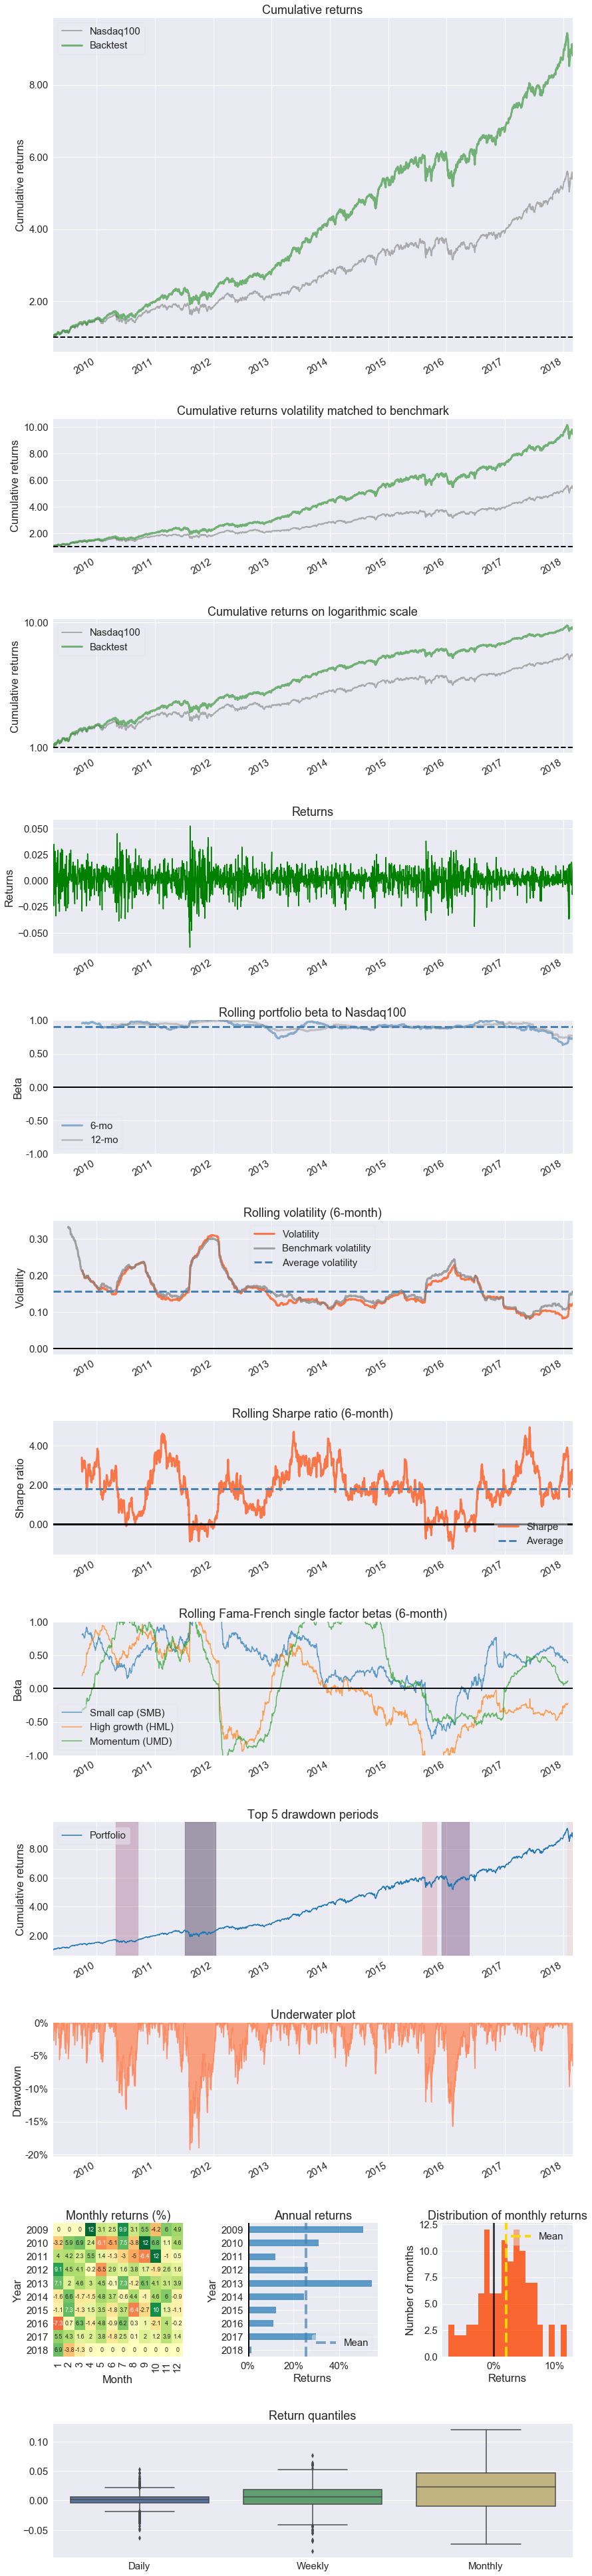

In [70]:
pyfolio_analyze(returns3.rename('Equal_Risk_Contribution_weight'),NDXreturn.rename('Nasdaq100'))

### 2.6 Further Research - Market cap and return

I believe it is quite important to figure out the logic behind the data. I performed a simple analysis of the relation between the stock weightings in Nasdaq 100 and the corresponding companies' mean daliy return.

In [83]:
#Weight top 10
NDXweights = pd.read_csv("C:/Users/Yunzhe Fang/Desktop/yewno/2. Smart Beta/1.data/nasdaq100Weights.csv",index_col="Symbol")
NDXweights.head(10)

Weight (%)
Symbol            
AAPL         10.41
MSFT          8.12
AMZN          6.53
FB            5.22
GOOG          4.81
GOOGL         4.24
INTC          3.00
CMCSA         2.96
CSCO          2.80
AMGN          2.36

The scatter shows that expect for those "tech giants" such as Apple and Amazon, most small cap companies have higher returns. 

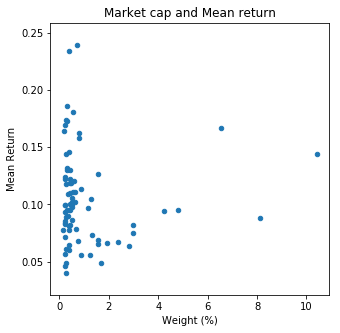

In [86]:
relation = pd.DataFrame(DailyReturn.mean(),columns=["Mean Return"]).rename_axis('Symbol')
relation = pd.merge(NDXweights,relation,how="inner",left_index=True, right_index=True)
relation.plot(kind='scatter',x="Weight (%)",y="Mean Return",figsize=(5,5)).set_title("Market cap and Mean return")

plt.show()

## 3 Conclusion
<b>Analysis:</font></b><br>
I think the most reason that makes these three strategies outperform the benchmark is <b>"more equally weighted"</b>. The Nasdaq 100 index is high concentrated, as the top 10 market caps of the Nasdaq 100 account for around 50%. At the same time, big companies usually grew slower than the small companies and have relatively lower returns. That's why when the weightings gets more equally, the portfolio's return gets higher.

On the other hand, Nasdaq contains all the high-tech industries. High-tech companies are growing much faster than the traditional companies because of the technology revolution today. I believe Nasdaq is a great market to invest - we invest "out future".

Still, disadvantages of the three smart beta strategies exists.

<b>1. Liquidity limited: </b><br> Most of the small cap companies don't have good liquidity, which means these three smart beta index may not have good liquidity as well, or more transaction costs are required.

<b>2. Unstable development: </b><br> Although all the three smart beta strategies are based on risk, unstable development of the small companies would bring us more risk - such as "disastrous rare events".

<b>3. Market systematic risks: </b><br> such as High-tech bubble. High-tech industries tend to generate bubbles because people could hardly understand and evaluate those technologies.
